# Tropical rainbelt: structure

### Package

In [1]:
import sys
sys.path.append('/work/mh0731/m300876/package/')
import icons
import intake
import healpy as hp
import xarray as xr
import numpy as np
import easygems.healpix as egh
from scipy.ndimage import gaussian_filter
from pathlib import Path
import seaborn as sns

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
icons.prepare_cpu(memory='100GB')

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Workers: 1
Total threads: 256,Total memory: 93.13 GiB
Status: running,Using processes: False
Comm: inproc://136.172.120.71/2443070/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 93.13 GiB
Comm: inproc://136.172.120.71/2443070/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/39677/status,Memory: 93.13 GiB
Nanny: None,


### Predefined functions

In [3]:
### preprocess to modify data set
def preprocess(ds):
    """
    Adapts precipitation to the needs of this notebook.
    """
    ds = ds.assign(pr=(ds.pr * 86400).assign_attrs(units="mm d-1"))
    return ds

### Location mask
def tropics(ds):
    return np.abs(ds.lat) <= 30.1

def trop_wpacific(ds):
    return tropics(ds) & (ds.lon > 150) & (ds.lon < 170) 

#### calculate mean in IMERG
def time_clim_imerg(file, times, lat):
    dset1 = xr.open_mfdataset(
        file, combine="by_coords", chunks=({"time": 20}), engine="netcdf4"
    )
    pr = (
        dset1["calibrated_precipitation"]
        .sel(time=slice(times[0], times[1]), lat=slice(lat[0], lat[1]))
        .groupby("time.month")
        .mean()
    )
    return pr.compute()


## Calling data

In [4]:
%%time
### ICON
current_location = "online"
cat = cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
exp_name = "icon_d3hp003"
experiment = cat[exp_name]
time_slice = slice("2020-02-01", "2021-01-31")
ds_icon = (
    experiment(zoom=8, time="P1D", chunks="auto")
    .to_dask()
    .pipe(egh.attach_coords)
    .pipe(preprocess)
    .sel(time=time_slice)
)

pr_icon = ds_icon.pr.where(tropics(ds_icon)).mean("time").compute()

CPU times: user 6.19 s, sys: 4.8 s, total: 11 s
Wall time: 9.91 s


In [9]:
%%time
### NICAM
exp_name = "nicam_gl11"
experiment = cat[exp_name]
time_slice = slice("2020-04-01", "2021-03-31")
ds_nicam = (
    experiment(zoom=8, time="PT3H", chunks="auto")
    .to_dask()
    .pipe(preprocess)
    .sel(time=time_slice)
)

ds_nicam = ds_nicam.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)

pr_nicam = ds_nicam.pr.where(tropics(ds_nicam)).mean("time").compute()

CPU times: user 2min 35s, sys: 40.3 s, total: 3min 15s
Wall time: 2min 26s


In [6]:
%%time
### Unified Model
exp_name = "um_glm_n2560_RAL3p3"
experiment = cat[exp_name]
time_slice = slice("2020-03-01", "2021-03-01")
ds_um = (
    experiment(zoom=8, time="PT1H", chunks="auto")
    .to_dask()
    .pipe(preprocess)
    .sel(time=time_slice)
)

ds_um = ds_um.assign_coords(
    lat=(("cell",), ds_icon.lat.values, {"units": "degree_north"}),
    lon=(("cell",), ds_icon.lon.values, {"units": "degree_east"}),
)

pr_um = ds_um.pr.where(tropics(ds_um)).mean("time").compute()

CPU times: user 2min 57s, sys: 1min 15s, total: 4min 12s
Wall time: 2min 59s


In [7]:
%%time
## IMERG
# Define a global pattern to find the files
glob_pattern_3d1 = "IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_"
## Define the paths of IMERG
data_path1 = Path(
    "/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG"
)
## Collect all file names with pathlib'
file_imerg = sorted([str(f) for f in data_path1.rglob(f"*{glob_pattern_3d1}*.nc")])[:]
pr_imerg = time_clim_imerg(file_imerg, ["2001-01-01", "2020-12-31"], [-30, 30]).mean(
    "month"
)

CPU times: user 1min 18s, sys: 2min 5s, total: 3min 24s
Wall time: 1min 20s


## Estimate the tropical rainbelt

In [10]:
trb_icon_hl = (pr_icon.where(pr_icon > pr_icon.quantile(0.8), 0) / pr_icon )
trb_nicam_hl = (pr_nicam.where(pr_nicam > pr_nicam.quantile(0.8), 0) / pr_nicam)
trb_um_hl = (pr_um.where(pr_um > pr_um.quantile(0.8), 0) / pr_um )

## Plotting

In [11]:
import cartopy as cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

### Predefined functions

In [12]:
### Smoothing for plotting
def filer_graphic(
    xarray,
    xlims=[-180, 180],
    ylims=[-30, 30],
    nx=3600,
    ny=600,
    projection=ccrs.PlateCarree(),
    method="linear",
    smoothness=4,
):

    xarray_resample = egh.healpix_resample(
        xarray, xlims, ylims, nx, ny, projection, method
    ).rename({"x": "lon", "y": "lat"})

    filter_data = xr.DataArray(
        gaussian_filter(xarray_resample, smoothness),
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], xarray_resample.lon.values),
            lat=(["lat"], xarray_resample.lat.values),
        ),
    )
    return filter_data

###Custom plot for troics
def tropdmap(var, **kwargs):
    projection = ccrs.PlateCarree(central_longitude=-135.5808361)
    sns.set_context("paper")
    fig, ax = plt.subplots(
        figsize=(16/2.54, 16/2.54), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor="gray", alpha=0.25)
    cs = egh.healpix_show(var, ax=ax, **kwargs)
    ax.set_ylim(-30,30)
    ax.spines.geo.set_visible(False)
    return ax

##Customizing colormap
cmap_w_b = ListedColormap(["w", "b"])
bounds_w_b = [0, 0.5]
norm_w_b = BoundaryNorm(bounds_w_b, cmap_w_b.N)

### Plots

#### Tropical Rainbelt 

In [13]:
#### smoothing imerg
smooth_pr_imerg = xr.DataArray(
    gaussian_filter(pr_imerg, 2),
    dims=["lat", "lon"],
    coords=dict(
        lon=(["lon"], pr_imerg.lon.values),
        lat=(["lat"], pr_imerg.lat.values),
    ),
)

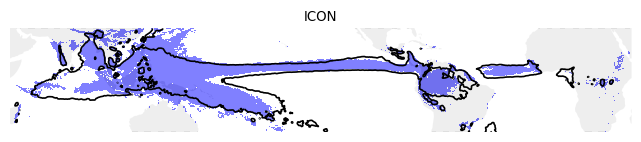

In [14]:
ax = tropdmap(trb_icon_hl,cmap=cmap_w_b,
        norm=norm_w_b,alpha=0.5)
smooth_pr_imerg.plot.contour(levels=[pr_imerg.quantile(0.8)], colors="k",transform=ccrs.PlateCarree());
ax.set_title('ICON');

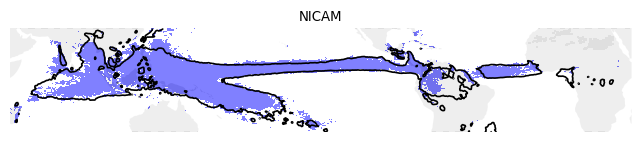

In [15]:
ax = tropdmap(trb_nicam_hl,cmap=cmap_w_b,
        norm=norm_w_b,alpha=0.5)
smooth_pr_imerg.plot.contour(levels=[pr_imerg.quantile(0.8)], colors="k",transform=ccrs.PlateCarree())
ax.set_title('NICAM');

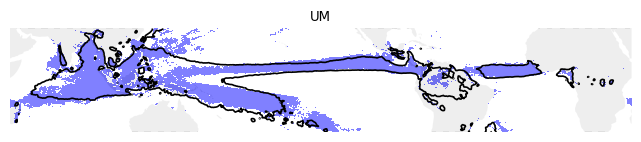

In [16]:
ax = tropdmap(trb_um_hl,cmap=cmap_w_b,
        norm=norm_w_b,alpha=0.5)
smooth_pr_imerg.plot.contour(levels=[pr_imerg.quantile(0.8)], colors="k",transform=ccrs.PlateCarree())
ax.set_title('UM');

#### Zonal mean

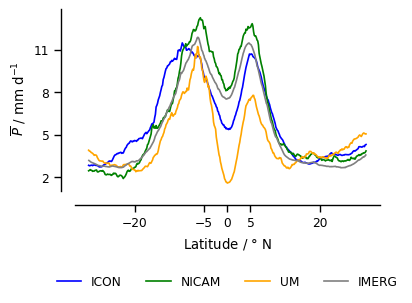

In [17]:
sns.set_context("paper")
fig = plt.figure(figsize=(10/2.54, 6/2.54), facecolor="white")
ax = fig.add_subplot(111)
pr_icon.where(trop_wpacific(pr_icon)).groupby('lat').mean().plot(label='ICON',color='blue')
pr_nicam.where(trop_wpacific(pr_nicam)).groupby('lat').mean().plot(label='NICAM',color='green')
pr_um.where(trop_wpacific(pr_um)).groupby('lat').mean().plot(label='UM',color='orange')
pr_imerg.sel(lon=slice(150,170),lat=slice(-30,30)).mean('lon').plot(label='IMERG',color='gray')
sns.despine(offset=10, ax=ax)
ax.set_xticks([-20,-5,0,5,20])
ax.set_yticks([2, 5, 8, 11])
ax.set_xlabel(None)
ax.set_ylabel(r" $\overline{P}$ / mm d$^{-1}$")
ax.set_xlabel(r"Latitude / $\degree$ N")
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.4),
    ncol=4,
    fancybox=False,
    shadow=False,
    frameon=False
)